# <center> Практика. Статистические тесты в контексте EDA

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы:

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.

2. А также ответить на ключевые вопросы HR-агентства:
    - Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    - Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    - Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    - Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

На каждый вопрос необходимо ответить с уровнем значимости $\alpha=0.05$.

Ответить на поставленные вопросы нам помогут предоставленные данные:

- work_year - Год, в котором была выплачена зарплата.

- experience_level - Опыт работы на этой должности в течение года со следующими возможными значениями:
    - EN — Entry-level/Junior;
    - MI — Mid-level/Intermediate;
    - SE — Senior-level/Expert;
    - EX — Executive-level/Director.
    
- employment_type - Тип трудоустройства для этой роли:
    - PT — неполный рабочий день;
    - FT — полный рабочий день;
    - CT — контракт;
    - FL — фриланс.
- job_title - Роль, в которой соискатель работал в течение года.

- salary - Общая выплаченная валовая сумма заработной платы.

- salary_currency - Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.

- salary_in_usd - Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).

- employee_residence - Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.

- remote_ratio - Общий объём работы, выполняемой удалённо. Возможные значения:
    - 0 — удалённой работы нет (менее 20 %);
    - 50 — частично удалённая работа;
    - 100 — полностью удалённая работа (более 80 %).

- company_location - Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.

- company_size - Среднее количество людей, работавших в компании в течение года:
    - S — менее 50 сотрудников (небольшая компания);
    - M — от 50 до 250 сотрудников (средняя компания);
    - L — более 250 сотрудников (крупная компания).

In [1]:
# импортируем необходимые библиотеки

import pandas as pd
from sklearn import datasets
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.contingency_tables import mcnemar

# делаем визуальную настройку графиков

sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [2]:
# Загружаем данные и выведем начало датасета

data = pd.read_csv('data/ds_salaries.csv')
display(data.head(3))



,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M


In [3]:
#задаем уровень значимости alpha

alpha = 0.05
print(f'Уровень значимости alpha = {alpha}')

Уровень значимости alpha = 0.05


 ## EDA - Описательный анализ данных ##

In [4]:
# Выводим основную иноформацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В датасете 607 записей, пропущенных значений нет. 

Из предоставленных данных можно выделить следующие признаки как категориальные и количественные:

Категориальные признаки:

- __work_year__
- __experience_level__
- __employment_type__
- __job_title__
- __salary_currency__
- __employee_residence__
- __company_location__
- __company_size__
- __remote_ratio__

Количественные признаки:

- __salary__
- __salary_in_usd__


Ниже перечисленные признаки можно будет удалить, так как они не будут участвовать в исследовании:

- __Unnamed: 0__: Этот признак кажется лишним, поскольку он, вероятно, представляет собой индекс или идентификатор записи. 

- __salary_currency__ и __salary__: Если есть столбец __salary_in_usd__ для приведения всех зарплат к одной валюте (USD), то столбцы __salary_currency__ и __salary могут__ быть удалены, так как они уже несут дублирующую информацию.
- __employee_residence__ и __company_location__ : данная информация не будет использоваться в исследовании

In [5]:
# Уберем ненужные признаки
data = data.drop(['Unnamed: 0', 'salary', 'salary_currency', 'company_location', 'employee_residence'], axis=1)



In [6]:
# Преобразуем признак work_year и remote_ratio в object
data['work_year'] = data['work_year'].astype('object')
data['remote_ratio'] = data['remote_ratio'].astype('object')

In [7]:
# Проверяем датасет на наличие дубликатов
duplicates = data[data.duplicated()].shape[0]
print(f'Количество дубликатов составляет: {duplicates}')

# Удаляем дубликаты

data = data.drop_duplicates()
print(f'Размер датасета после удаления дубликатов: {data.shape}')

Количество дубликатов составляет: 48
Размер датасета после удаления дубликатов: (559, 7)


In [8]:
# Добавим новый признак 'DE_DS', чтобы иметь возможность работать сразу с группой должностей, 
# относящихся к Data Scientist и Data Engineer 

data['DE_DS'] = data['job_title'].apply(lambda x: 'yes' if x =='Data Engineer' or x == 'Data Scientist' else 'no')


In [9]:
# Заменим значения в признаках experience_level, employment_type и company_size для лучшего отображения на графиках


data['experience_level'] = data['experience_level'].replace('EN', 'Entry-level/Junior')
data['experience_level'] = data['experience_level'].replace('EX', 'Executive-level/Director')
data['experience_level'] = data['experience_level'].replace('MI', 'Mid-level/Intermediate')
data['experience_level'] = data['experience_level'].replace('SE', 'Senior-level/Expert')

data['employment_type'] = data['employment_type'].replace('FT', 'полный рабочий день')
data['employment_type'] = data['employment_type'].replace('CT', 'контракт')
data['employment_type'] = data['employment_type'].replace('FL', 'фриланс')
data['employment_type'] = data['employment_type'].replace('PT', 'неполный рабочий день')

data['company_size'] = data['company_size'].replace('L', "Large")
data['company_size'] = data['company_size'].replace('M', "Medium")
data['company_size'] = data['company_size'].replace('S', "Small")

### Распределение зарплат для должности Data Scientist

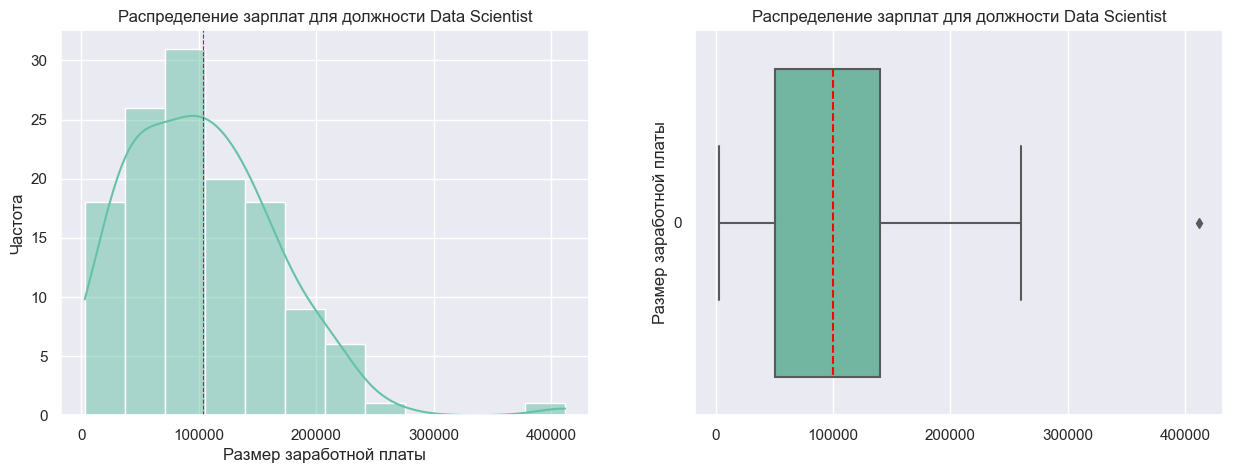

In [10]:
# отфильтруем данные для должности Data Scientist
filtered_data = data[data['job_title'] == 'Data Scientist']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(filtered_data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер заработной платы', ylabel='Частота')
axes[0].set_title('Распределение зарплат для должности Data Scientist')
axes[0].axvline(filtered_data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(filtered_data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер заработной платы')
axes[1].set_title('Распределение зарплат для должности Data Scientist')

plt.show()

In [11]:
salary_statisctics = filtered_data['salary_in_usd'].describe().round(2).to_frame()
salary_statisctics.columns = ['Размер зарплат Data Scientist']
display(salary_statisctics)

,Размер зарплат Data Scientist
count,130.00
mean,103336.35
std,63967.56
min,2859.00
25%,50330.25
50%,100000.00
75%,140400.00
max,412000.00


Распределение зарплат отлично от нормального, имеются выбросы.

### Уровень зарплат Data Scientist и Data Engineer в 2022 году

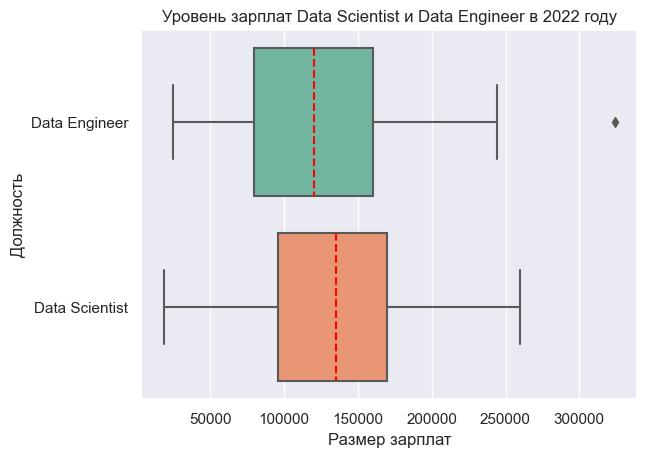

In [12]:
# Отфильтруем данные для должностей Data Scientist  и Data Engineer и 2022 года
filtered_data = data[(data['work_year'] == 2022) & ((data['job_title'] == 'Data Scientist') | (data['job_title'] == 'Data Engineer')) ]

ax = sns.boxplot(filtered_data, x='salary_in_usd', y='job_title', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Должность')
plt.title('Уровень зарплат Data Scientist и Data Engineer в 2022 году')
plt.show()

In [13]:
salary_statisctics = filtered_data.groupby('job_title')['salary_in_usd'].describe().round(2)
print('')
display(salary_statisctics)

,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Engineer,75.0,127562.79,57849.77,25000.0,79263.0,120000.0,160080.0,324000.0
Data Scientist,65.0,131366.94,55785.24,18442.0,95550.0,135000.0,170000.0,260000.0


При первом приближении кажется, что уровень зарплат для должностей Data Science слегка выше, чем длю должностей Data Engineer. Статистические тестирования покажут, действительно ли это так.

### Уровень зарплаты Data Scientins в зависимости от опыта работы

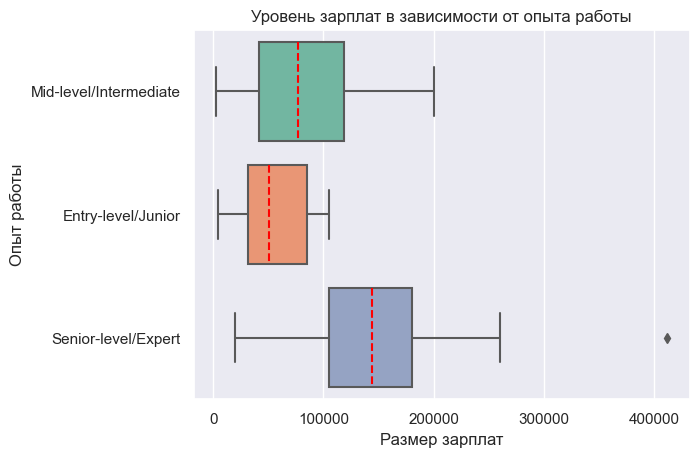

In [14]:
# отфильтруем данные для должности Data Scientist
filtered_data = data[data['job_title'] == 'Data Scientist']

ax = sns.boxplot(filtered_data, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Опыт работы')
plt.title('Уровень зарплат в зависимости от опыта работы')
plt.show()

In [15]:
salary_statisctics = filtered_data.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('')
display(salary_statisctics)

,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
Entry-level/Junior,22.0,55330.91,31237.82,4000.0,31474.0,50483.5,85027.25,105000.0
Mid-level/Intermediate,59.0,81891.76,47257.88,2859.0,41339.0,76958.0,118529.50,200000.0
Senior-level/Expert,49.0,150710.86,62918.63,20171.0,104890.0,144000.0,180000.00,412000.0


Судя по данным, опыт работы напрямую влияет на размер зарплаты. С увеличение опыта растет и зарплата. 

### Уровень зарплат Data Scientist в зависимости от типа трудоустройства

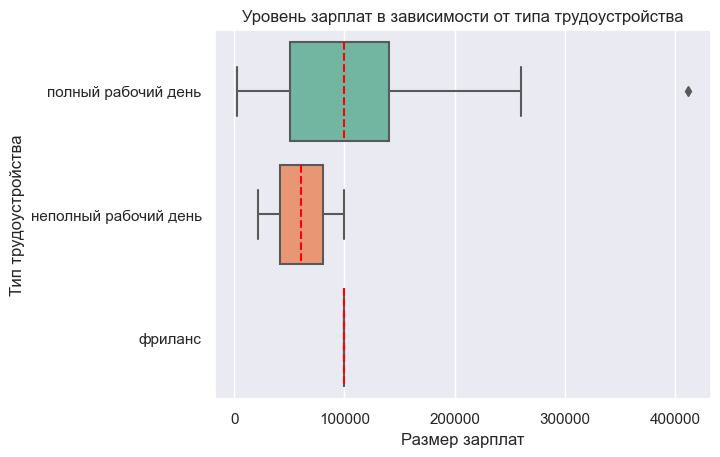

In [16]:
# отфильтруем данные для должности Data Scientist
filtered_data = data[data['job_title'] == 'Data Scientist']

ax = sns.boxplot(filtered_data, x='salary_in_usd', y='employment_type', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Тип трудоустройства')
plt.title('Уровень зарплат в зависимости от типа трудоустройства')
plt.show()

In [17]:
salary_statisctics = filtered_data.groupby('employment_type')['salary_in_usd'].describe().round(2)
print('')
display(salary_statisctics)

,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
неполный рабочий день,2.0,60834.50,55388.38,21669.0,41251.75,60834.5,80417.25,100000.0
полный рабочий день,127.0,104031.94,64309.23,2859.0,50660.50,100000.0,140850.00,412000.0
фриланс,1.0,100000.00,NaN,100000.0,100000.00,100000.0,100000.00,100000.0


Для работающих на фрилансе невозможны выявить зависимость уровня зарплаты от типа трудоустройства, так как в выборке присутствуют данные только об одном сотруднике. Сравнивая же работающих полный рабочий день и работников с частичной занятостью, первые получают значительно более высокую зарплату.

### Уровень зарплат Data Scientist в зависимости от размера компании

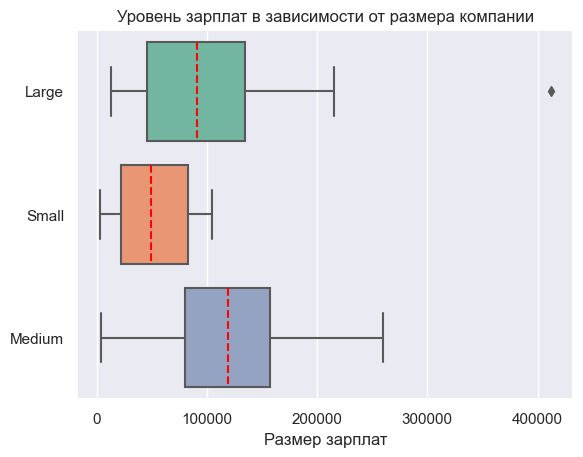

In [18]:
# отфильтруем данные для должности Data Scientist
filtered_data = data[data['job_title'] == 'Data Scientist']

ax = sns.boxplot(filtered_data, x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='')
plt.title('Уровень зарплат в зависимости от размера компании')
plt.show()

In [19]:
salary_statisctics = filtered_data.groupby('company_size')['salary_in_usd'].describe().round(2)
print('')
display(salary_statisctics)

,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
Large,43.0,102743.42,73254.10,13400.0,45240.5,90734.0,135000.0,412000.0
Medium,66.0,120080.58,56347.79,4000.0,80000.0,119529.5,157500.0,260000.0
Small,21.0,51925.76,33216.29,2859.0,21669.0,49268.0,82500.0,105000.0


Судя по графику и данным, зарплаты специалистов Data Science в небольших компаниях ниже, чем в средних и крупных. Сравнивая же уровень зарплат в средних и крупных компанию, в средних уровень дохода выше. Достоверно подтвердить данное утвержение можно будет с помощью статистических тестов далее в исследовании.


### Распределение зарплат Data Scientist по годам

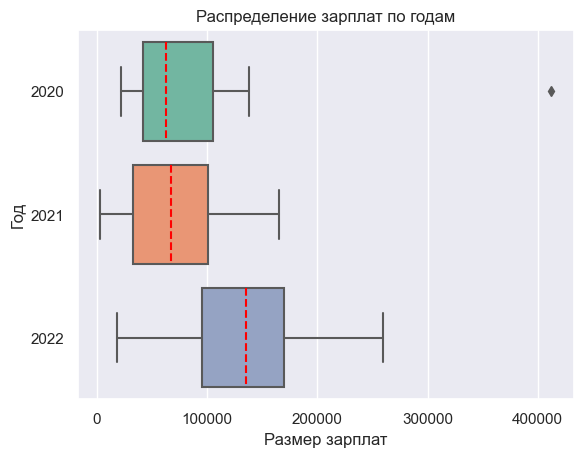

In [20]:
# отфильтруем данные для должности Data Scientist
filtered_data = data[data['job_title'] == 'Data Scientist']

ax = sns.boxplot(filtered_data, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Год')
plt.title('Распределение зарплат по годам')
plt.show()

In [21]:
salary_statisctics = filtered_data.groupby('work_year')['salary_in_usd'].describe().round(2)
print('')
display(salary_statisctics)

,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.52,81436.65,21669.0,42197.00,62726.0,105000.00,412000.0
2021,44.0,70215.77,45843.82,2859.0,32793.75,67233.5,100922.75,165000.0
2022,65.0,131366.94,55785.24,18442.0,95550.00,135000.0,170000.00,260000.0


Судя по графику и данным, наблюдается рост зарплат специалистов Data Science в 2022 году по сравнению с 2021 годом. Тогда как в 2021 году рост зарплаты не наблюдается. Достоверно подтвердить данное утвержение можно будет с помощью статистических тестов далее в исследовании.

### Распределение зарплат Data Scientist в зависимости от объема удаленной работы

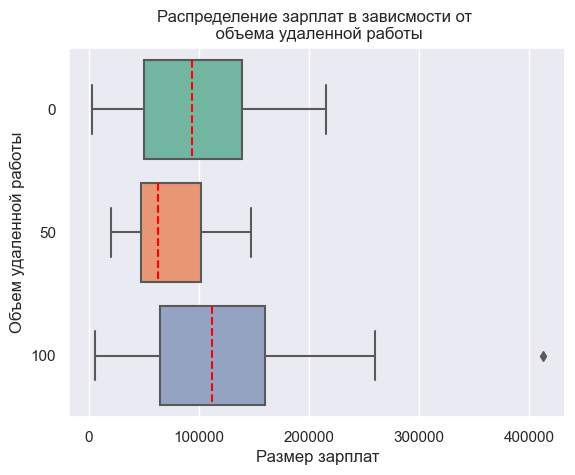

In [22]:
# отфильтруем данные для должности Data Scientist
filtered_data = data[data['job_title'] == 'Data Scientist']

ax = sns.boxplot(filtered_data, x='salary_in_usd', y='remote_ratio', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Объем удаленной работы')
plt.title('Распределение зарплат в зависмости от \n объема удаленной работы')
plt.show()

In [23]:
salary_statisctics = filtered_data.groupby('remote_ratio')['salary_in_usd'].describe().round(2)
print('')
display(salary_statisctics)

,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,38.0,98444.97,58647.60,2859.0,49781.25,93582.0,139050.0,215300.0
50,24.0,73827.83,36204.18,20171.0,47783.75,62726.0,102250.0,147000.0
100,68.0,116484.54,70908.36,5679.0,64420.00,111500.0,160000.0,412000.0


Судя по данным, 100% удаленная работа наиболее высоко оплачиваемая, далее идет 100% работа в офисе, и на последнем месте гибридный график (50% в офисе, 50% - из дома).

### Соотношение наличия должностей Data Scientist и Data Engineer с размером компании

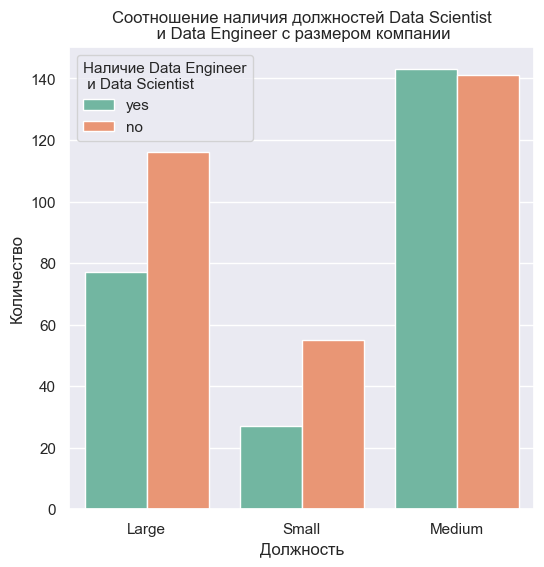

In [24]:

plt.figure(figsize=(6, 6))
ax = sns.countplot(data=data, x=data['company_size'], hue='DE_DS')
ax.set(xlabel='Должность', ylabel='Количество')
plt.legend(title = 'Наличие Data Engineer\n и Data Scientist', loc='best', alignment='left', title_fontsize='11')
plt.title('Соотношение наличия должностей Data Scientist\n и Data Engineer с размером компании')
plt.show()

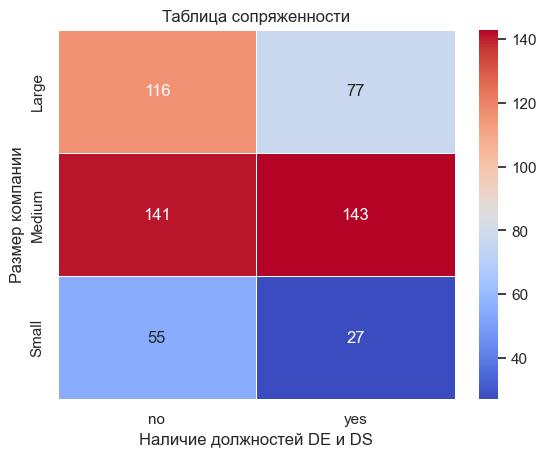

In [25]:
cross_tab = pd.crosstab(index=data['company_size'], columns=data['DE_DS'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Наличие должностей DE и DS', ylabel='Размер компании')
plt.title('Таблица сопряженности')
plt.show()

### Промежуточные итоги

Судя по данным и графикам, наиболее высокую зарплату на должности Data Scientist получают сотрудники с уронем опыта Senior, работающие 100% удаленно и полный рабочий день, в средних по размеру компаниях. В 2022 году зарплаты у таких специалистов выросли, однако в 2021 году роста зарплаты не было. Больше всего сотрудников с должностями Data Scientist и Data Engineer работает в средних по размеру компаниях, причем у первых зарплаты выше.

## Статистический анализ данных

In [26]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы для сравнения 2020 и 2021 годов:**

*Нулевая гипотеза* ($H_0$): уровень зарплат в 2021 году ($μ_1$) статистически меньше либо равен уровню зарплат в 2020 году ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): уровень зарплат в 2021 году  ($μ_1$) статистически больше, чем уровень зарплат в 2020 году ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Сформулируем нулевую и альтернативные гипотезы для сравнения 2021 и 2022 годов:**

*Нулевая гипотеза* ($H_0$): уровень зарплат в 2022 году ($μ_1$) статистически меньше либо равен уровню зарплат в 2021 году ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$):уровень зарплат в 2022 году ($μ_1$) статистически больше, чем уровень зарплат в 2021 году ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [27]:
# отфильтруем данные для должности Data Scientist
filtered_data = data[data['job_title'] == 'Data Scientist']

# значения зарплат
salaries_2020 = filtered_data.loc[filtered_data['work_year']==2020, 'salary_in_usd']
salaries_2021 = filtered_data.loc[filtered_data['work_year']==2021, 'salary_in_usd']
salaries_2022 = filtered_data.loc[filtered_data['work_year']==2022, 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для 2020 года:')
result = stats.shapiro(salaries_2020)
decision_normality(result[1])

print('Для 2021 года:')
result = stats.shapiro(salaries_2021)
decision_normality(result[1])

print('Для 2022 года:')
result = stats.shapiro(salaries_2022)
decision_normality(result[1])


Для 2020 года:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2021 года:
p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2022 года:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «salary_in_usd»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — распределение для 2020 года не явлется нормальным, для 2021 и  2022 года является нормальным.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов для сравнения 2020 и 2021 годов, так как один из признаков не распределен нормально. Для сравнения 2021 и 2022 года будем использовать двухвыборочный t-критерий (t-test).

**Проведём тест**

In [28]:
# проводим тест для сравнения 2020 и 2021 годов
_, p = stats.mannwhitneyu(salaries_2021, salaries_2020, alternative='greater')
decision_hypothesis(p)

# также проверим, были ли зарплаты в 2020 и 2021 годах равны (это будет нулевая гипотеза)
_, p = stats.mannwhitneyu(salaries_2021, salaries_2020, alternative='two-sided')
decision_hypothesis(p)

p-value = 0.705
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
p-value = 0.599
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


In [39]:
# проводим тест для сравнения 2021 и 2022 годов
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(salaries_2022, salaries_2021)
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.ttest_ind(salaries_2022, salaries_2021, alternative='greater', equal_var=True)

decision_hypothesis(p)

Тест на равенство дисперсий
p-value = 0.264
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.

Тест на равенство средних
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Сравнивая 2020 год с 2021, и 2021 с 2022, наблюдается рост зарплат только в 2022 году. В 2020 и  2021 годах зарплаты находились на одном уровне.

### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

**Сформулируем нулевую и альтернативные гипотезы:**

*Нулевая гипотеза* ($H_0$): уровень зарплат Data Scientist в 2022 году ($μ_1$) статистически равен уровню зарплат Data Engineer в 2022 году($μ_2$).

$$ H_0 : μ_1 = μ_2$$

*Альтернативная гипотеза* ($H_1$): уровень зарплат Data Scientist в 2022 году  ($μ_1$) статистически не равен уровню зарплат Data Engineer в 2022 году ($μ_2$).

$$ H_1 : μ_1 \neq μ_2$$



**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [30]:
# значения зарплат
filtered_data = data[data['work_year'] == 2022]

salaries_DS = filtered_data.loc[filtered_data['job_title']=='Data Scientist', 'salary_in_usd']
salaries_DE = filtered_data.loc[filtered_data['job_title']=='Data Engineer', 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для зарплат Data Scientis в 2022 году:')
result = stats.shapiro(salaries_DS)
decision_normality(result[1])

print('Для зарплат Data Engineer в 2022 году:')
result = stats.shapiro(salaries_DE)
decision_normality(result[1])



Для зарплат Data Scientis в 2022 году:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для зарплат Data Engineer в 2022 году:
p-value = 0.022
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «salary_in_usd»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Один из признаков распределен, второй - нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

**Проведём тест**

In [31]:
# проводим тест 
_, p = stats.mannwhitneyu(salaries_DS, salaries_DE, alternative='two-sided')
decision_hypothesis(p)

p-value = 0.506
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нет основания отвергнуть нулевую гипотезу, уровни зарплат специалистов с должностями Data Scientist и Data Engineer статистически равны.

### Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер зарплаты специалистов Data Scientist не отличается в компаниях различных размеров: small ($μ_1$), medium ($μ_2$), large ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: размер зарплаты специалистов Data Scientist отличается в компаниях различных размеров: small ($μ_1$), medium ($μ_2$), large ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [32]:
# отфильтруем данные для должности Data Scientist
filtered_data = data[data['job_title'] == 'Data Scientist']

# значения зарплат
salaries_small = filtered_data.loc[filtered_data['company_size']=='Small', 'salary_in_usd']
salaries_medium = filtered_data.loc[filtered_data['company_size']=='Medium', 'salary_in_usd']
salaries_large = filtered_data.loc[filtered_data['company_size']=='Large', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для маленьких компаний:')
result = stats.shapiro(salaries_small)
decision_normality(result[1])

print('Для средних компаний:')
result = stats.shapiro(salaries_medium)
decision_normality(result[1])

print('Для крупных компаний:')
result = stats.shapiro(salaries_large)
decision_normality(result[1])

Для маленьких компаний:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для средних компаний:
p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для крупных компаний:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «salary_in_usd»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — 1 из 3 признаков не распределен нормально. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [33]:
# проводим тест
_, p = stats.kruskal(salaries_small, salaries_medium, salaries_large)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Отвергаем нулевую гипотезу в пользу альтернативной, размер зарплаты специалистов Data Scientist отличается в компаниях различных размеров.

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между наличием должностей Data Scientist и Data Engineer и размером компании нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между наличием должностей Data Scientist и Data Engineer и размером компаниим есть взаимосвязь (признаки зависимы).

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «company_size»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [34]:
# составляем таблицу сопряжённости
cross_tab = pd.crosstab(index=data['company_size'], columns=data['DE_DS'])

cross_tab

DE_DS,no,yes
company_size,,
Large,116,77
Medium,141,143
Small,55,27


In [35]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_tab)
decision_hypothesis(p)

p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Существует статистически значимая взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании.

### Дополнительные исследования:

#### Исследование №1. Наблюдается ли рост зарплат специалистов с должностью Data Scientist с ростом опыта?
#### Исследование №2. Можно ли утверждать, что при 100% уровне удаленной работы доходы специалистов с должность Data Scientist выше, чем при работе в офисе?

### Наблюдается ли рост зарплат специалистов с должностью Data Scientist с ростом опыта?

**Сформулируем нулевую и альтернативные гипотезы для сравнения Entry-level/Junior и Mid-level/Intermediate:**

*Нулевая гипотеза* ($H_0$): уровень зарплат Mid-level/Intermediate ($μ_1$) статистически меньше либо равен уровню зарплат Entry-level/Junior ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): уровень зарплат Mid-level/Intermediate  ($μ_1$) статистически больше, чем уровень зарплат Entry-level/Junior ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Сформулируем нулевую и альтернативные гипотезы для сравнения Mid-level/Intermediate и Senior-level/Expert:**

*Нулевая гипотеза* ($H_0$): уровень зарплат Senior-level/Expert ($μ_1$) статистически меньше либо равен уровню зарплат Mid-level/Intermediate ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): уровень зарплат Senior-level/Expert  ($μ_1$) статистически больше, чем уровень зарплат Mid-level/Intermediate ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [37]:
# отфильтруем данные для должности Data Scientist
filtered_data = data[data['job_title'] == 'Data Scientist']

# значения зарплат
salaries_junior = filtered_data.loc[filtered_data['experience_level']=='Entry-level/Junior', 'salary_in_usd']
salaries_middle = filtered_data.loc[filtered_data['experience_level']=='Mid-level/Intermediate', 'salary_in_usd']
salaries_senior = filtered_data.loc[filtered_data['experience_level']=='Senior-level/Expert', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для Entry-level/Junior:')
result = stats.shapiro(salaries_junior)
decision_normality(result[1])

print('Для Mid-level/Intermediate:')
result = stats.shapiro(salaries_middle)
decision_normality(result[1])

print('Для Senior-level/Expert:')
result = stats.shapiro(salaries_senior)
decision_normality(result[1])


Для Entry-level/Junior:
p-value = 0.174
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Mid-level/Intermediate:
p-value = 0.146
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Senior-level/Expert:
p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «salary_in_usd»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — распределение зарплат для Entry-level/Junior и Mid-level/Intermediate является нормальным. Для Senior-level/Expert не является нормальным.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов для сравнения уровней зарплат Mid-level/Intermediate и Senior-level/Expert. Однако для сравнения зарплат Entry-level/Junior и Mid-level/Intermediate будем использовать будем использовать двухвыборочный t-критерий (t-test), так как эти признаки распределены нормально.

**Проведём тест**

In [41]:
# проводим тест для сравнения Entry-level/Junior и Mid-level/Intermediate
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(salaries_middle, salaries_junior)
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.ttest_ind(salaries_middle, salaries_junior, alternative='greater', equal_var=False)

decision_hypothesis(p)

Тест на равенство дисперсий
p-value = 0.025
Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.

Тест на равенство средних
p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


In [43]:
# проводим тест для сравнения зарплат Mid-level/Intermediate и Senior-level/Expert
_, p = stats.mannwhitneyu(salaries_senior, salaries_middle, alternative='greater')
decision_hypothesis(p)



p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Для специалистов с должностью Data Scientist уровень зарплаты растет с ростом опыта.

### Можно ли утверждать, что при 100% уровне удаленной работы доходы специалистов с должность Data Scientist выше, чем при работе в офисе?

**Сформулируем нулевую и альтернативные гипотезы:**

*Нулевая гипотеза* ($H_0$): уровень зарплат при 100% уровне удаленной работы ($μ_1$) статистически меньше либо равен уровню зарплат при 100% уровне работы в офисе ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): уровень зарплат при при 100% уровне удаленной работы ($μ_1$) статистически больше, чем уровень зарплат при 100% уровне работы в офисе ($μ_2$).

$$ H_1 : μ_1 > μ_2$$



**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [44]:
# отфильтруем данные для должности Data Scientist
filtered_data = data[data['job_title'] == 'Data Scientist']

# значения зарплат
salaries_remote = filtered_data.loc[filtered_data['remote_ratio']==100, 'salary_in_usd']
salaries_office = filtered_data.loc[filtered_data['remote_ratio']==0, 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для 100% уроня удаленной работы:')
result = stats.shapiro(salaries_remote)
decision_normality(result[1])

print('Для 100% уровня офисной работы:')
result = stats.shapiro(salaries_middle)
decision_normality(result[1])


Для 100% уроня удаленной работы:
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 100% уровня офисной работы:
p-value = 0.146
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «salary_in_usd»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — один из признаков не распределен нормально.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

**Проведём тест**

In [46]:
# проводим тест
_, p = stats.mannwhitneyu(salaries_remote, salaries_office, alternative='greater')
decision_hypothesis(p)

# также проверим, равны ли доходы при 100% уровнях работы в офисе и удаленно - нулевая гипотеза: доходы равны
_, p = stats.mannwhitneyu(salaries_remote, salaries_office, alternative='two-sided')
decision_hypothesis(p)

p-value = 0.117
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
p-value = 0.233
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Мы не можем утверждать, что 100% удаленная работа приносит больший доход, чем работа в офисе. Можно сказать, что работающие 100% удаленно сотрудники имеют равный офисным сотрудникам доход.

## Итоговые результаты исследования

*   Нет оснований утверждать, что имелся рост зарплат в 2021 году. Однако в 2022 году рост зарплат имеет место быть.
*   Размер зарплаты Data Scientist и Data Engineer в 2022 году равны.
*   Можно утверждать, что размер зарплаты специалистов Data Scientist отличается в компаниях различных размеров.
*   Существует взаимосвязь между между наличием должностей Data Scientist и Data Engineer и размером компании.
*   Для специалистов с должностью Data Scientist уровень зарплаты растет с ростом опыта.
*   Работая удаленно или офисе можно рассчитивать на равный уровень дохода.
